### Practice 2 - Evaluating risk

Markos Flavio B. G. O.

__Context: Risk and return of assets.__

__Course: Portfolio Selection and Risk Management (Coursera, Rice University)__

Estimate different metrics of asset risk.
    
__Specific objectives__

     1. Building Gaussian models from data sets of past returns to explain the distributions.
     2. Estimating the data using Kernel density estimators.
     3. Evaluating skewness and kurtosis.
     4. Evaluating VaR (Value-at-risk) and Expected shortfall.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import sys, os

#### 1. Building Gaussian models from data sets of past returns to explain the distributions

In [32]:
loc = r'D:\Dropbox\_Studies\Current Projects\Stock Market\Coursera\Rice University, Portfolio Selection and Risk Management\Notebooks\Data\data1.csv'
df = pd.read_csv(loc, index_col=0)

# formatting
df[df.columns] = df[df.columns].replace({'%': ''}, regex=True)
df[df.columns] = df[df.columns].apply(pd.to_numeric)
df.index = pd.to_datetime(df.index)
df.sort_index(ascending=True).head()
df.head()

,APPL,WALMART,IBM,NIKE
2011-01-31,5.20,3.97,10.38,-3.44
2011-02-28,4.09,-7.29,0.32,7.94
2011-03-31,-1.33,0.84,0.74,-14.67
2011-04-29,0.47,5.63,4.61,8.75
2011-05-31,-0.66,1.10,-0.52,2.59


We'll describe the data sets of returns of each ticker using a normal distribution, by computing expected values and standard deviations.

In [3]:
def get_normal_model(df, time_range=None):
    '''
    Calculates the expected return and volatility of each ticker in a Data Frame.
    
    Parameters:
        df (DataFrame): a DataFrame where the index has type 'datetime64' and columns are percentage changes in price.
        time_range (list): a list with size two, specifying a date range (in format '%d/%m/%Y'). If None, all samples are used.
    Returns:
        df_results (DataFrame): a DataFrame with:
            - The expected return.
            - The standard deviation.
    '''
    if time_range:
        df = df[(df.index >= datetime.strptime(time_range[0], '%d/%m/%Y')) & (df.index <= datetime.strptime(time_range[1], '%d/%m/%Y'))]
   
    #df = df/100 + 1 # getting the gross return
    df_sigma = df.apply(np.std)
    df_mu = df.apply(np.mean)
    
    df_results =  pd.concat([df_mu, df_sigma], axis=1)
    df_results.columns = ['Expected return', 'Standard deviation']
    #df_results = (df_results-1)*100 # getting back the percentages
    return df_results      

In [4]:
dfr = get_normal_model(df)
dfr

,Expected return,Standard deviation
APPL,1.755167,7.085197
WALMART,0.540000,4.775598
IBM,0.176833,4.506927
NIKE,2.103333,6.047588


#### Looking at the Gaussian models.

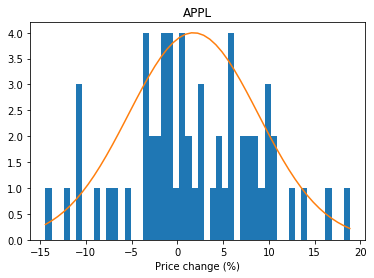

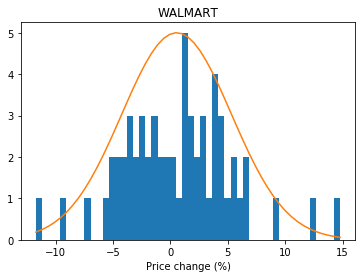

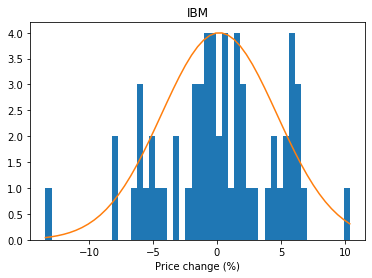

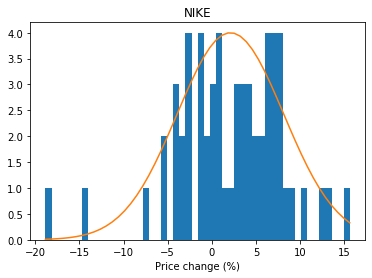

In [5]:
for symbol in df.columns:
    plt.figure()
    counts, bins, _ = plt.hist(df[symbol], bins=50)
    mu = dfr.loc[symbol]['Expected return']
    sigma = dfr.loc[symbol]['Standard deviation']
    h = max(counts)*sigma*(np.sqrt(np.pi*2)) # changing the height of the Guassian for better visualization
    plt.plot(bins, h*norm.pdf(bins, mu, sigma))
    plt.title(symbol)
    plt.xlabel('Price change (%)')

#### 2. Estimating the data using Kernel density estimators

Kernel density estimation is a way of estimating an unkown probability density function given some data. The idea is to find out the probabilities for possible value (or interval) of the random variable, without explicitly regarting to a particular probability distribution (such Normal).

This technique builds a kernel on the top of each data point, sums up all of the kernels and then normalizes to build the probability values. Here, we consider the Gaussian kernel. As more data points are available, the particular choice of the kernel becomes unimportant.

The Gaussian Kernel (as well as the others) also requires an additional parameter, called *bandwith*, which controls the dispersion of each kernel. An automatic way of finding the best bandwith value is by using Silverman's rule of thumb. It's still an important parameter even for large data sets.

Below we use two methods to estimate the pdf of the data:
   - KernelDensity from scikit-learn;
   - gaussian_kde from scipy

The second option appears to be better because allows one to use the Silverman's method to automatically choose the bandwith. Notice that in the plots the heights were increased for better visualization.

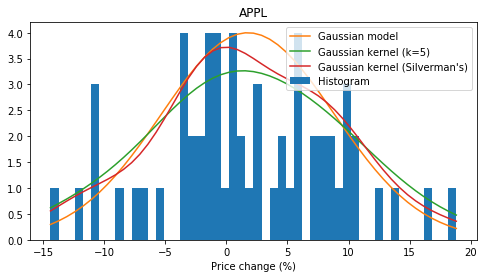

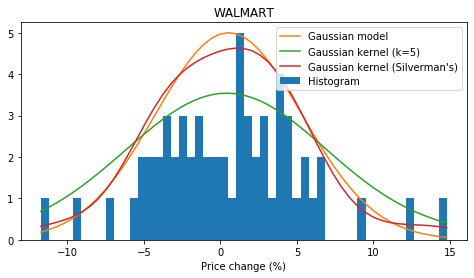

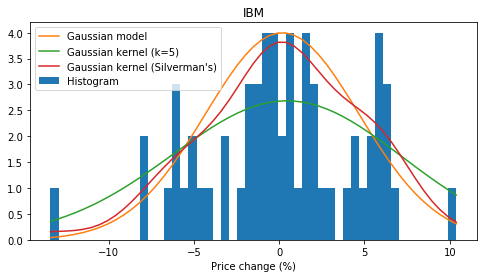

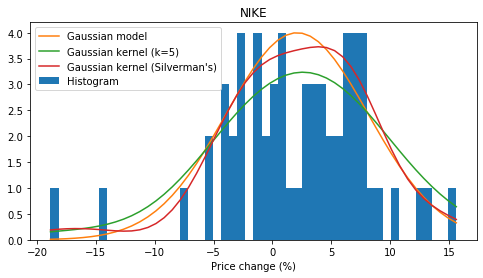

In [6]:
for symbol in df.columns:
    plt.figure(figsize=(8,4))
    counts, bins, _ = plt.hist(df[symbol], bins=50, label='Histogram')
    mu = dfr.loc[symbol]['Expected return']
    sigma = dfr.loc[symbol]['Standard deviation']
    h = max(counts)*sigma*(np.sqrt(np.pi*2)) # changing the height of the Guassian for better visualization
    plt.plot(bins, h*norm.pdf(bins, mu, sigma), label='Gaussian model')
    
    X = np.array(df[symbol]).reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(X)
    log_dens = kde.score_samples(np.array(bins).reshape(-1, 1))
    plt.plot(bins, h*np.exp(log_dens), label='Gaussian kernel (k=5)') # exp necessary because score_samples evalaute the log density model on the data.
    
    kde = stats.gaussian_kde(np.array(df[symbol])) # cannot be a 2D-array
    kde.set_bandwidth(bw_method='silverman')
    log_dens = kde(np.array(bins))
    plt.plot(bins, h*log_dens, label='Gaussian kernel (Silverman\'s)')
    plt.title(symbol)
    plt.xlabel('Price change (%)')
    plt.legend()

As we can see, the normal disttribution actually is a reasonable approximation for the data of price changes.

#### 3. Evaluating skewness and kurtosis

Skweness is a measure of assimmetry of the probability distribution. A Gaussian distribution has skewness of zero. If the actual distribution is skewed to the left, the Gaussian model is underestimating risk. That's because the standard deviation measures the deviation around the mean, without counting from which side this deviation comes:
  - from the right: good scenarios in investing, which means higher returns with respect to the mean.
  - from the left: bad scenarios; lower returns.
  
By modeling a normal distribution in negatively skewed data, expecting that to be zero, part of the existing risk of losses is discounted by assuming it comes from samples with returns higher than the mean (exactly, the contrary!). That's why measuring skeweness is important.

A classic way on interpreting skewness values s is given by Bulmer (1979):
  - s < -1 or s > 1: highly skewed.
  - -1 <= s < -1/2 or 1/2 > s >= 1: moderately skewed.
  - s >= -1/2 or s <= 1/2: approximately symmetric. 

In [7]:
df.skew()

APPL      -0.015359
WALMART    0.271386
IBM       -0.357529
NIKE      -0.724731
dtype: float64

As we can see, most of the equities have negative skewness values, which are expected (large losses are more common than large gains in stock market). Because NIKE has a reasonably high skewness value, we may expect it to suffer large losses than the others stocks during unstable economic periods; being the normal distribution an unreliable model in these contexts.

Interestingly, WALMART has a positive skewness value.

Kurtosis is a metric that measures the degree of fat tails of a data set. It measures the probability mass of extreme events or black swan events (far away from the mean, on both sides). In economics, stock investors have a high probability of suffering huge losses (and sometimes huge gains), in general, not predicted by Gaussian models, because the probability values becomes very low for values far away from the mean. That's because the decay rate is exponential for Gaussian models (which have a kurtosis of 3). Thus, these models often underestimate the occurence of great magnitude price variations.

In [8]:
df.kurtosis()+3 # +3 is summed up to return kurtosis standard's value (Gaussian = 3)

APPL       2.843533
WALMART    3.957210
IBM        3.268515
NIKE       4.924351
dtype: float64

None of the symbols have a very high kurtosis, however, all of them have kurtosis bigger than three (which make them leptokurtic), which means the Gaussian models are indeed underestimating the occurence of extreme events (oultiers, or very uncommon price varitions).

#### The Jarque-bera test.

The Jarque-bera (JB) test allows one to measure how the skeweness and kurtosis of a data set deviates from these features of a Gaussian distribution. It has no negative values, and as the values are increased, the similarity between the signal and the Normal is decreased.

In [9]:
for symbol in df.columns:
    print(symbol, stats.jarque_bera(df[symbol]))

APPL (0.1487594500656572, 0.9283191208964793)
WALMART (2.224481057406747, 0.3288214013338755)
IBM (1.2696975049688959, 0.5300156458052371)
NIKE (11.957850141656285, 0.0025315460628998476)


Considering that the null hypothesis assumes the samples come from a normal distribution. When the p-values are bigger than a significance level alpha = 0.05, we say that indeed the distributions are normal, with confidence level of 95%.

Based on this, only the data for NIKE symbol cannot be considered normally distributed, because the null hypothesis was rejected in this case.

#### 4. Evaluating VaR (Value-at-risk) and Expected shortfall

The Value-at-risk (VaR) metric is a simple measure that estimates the maximum loss of an investing strategy with a certain confidence:

*A stock has 95% VaR of 10 dollars, if the probability of a loss less than 10 dollars is 95% over a period.*  

A possible way to calculate the VaR in Python based on the Normal function is by using the percentage point function (ppf) from scipy. It's the inverse of the cumulative distribution function, i.e., it receives a percentage alpha (the significance level, or the opposite of the confidence level beta), and returns the value for the random variable at which this confidence holds.

<img src="Images/ppf.png" width='300'>

**Source:** http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/en_Tanagra_Calcul_P_Value.pdf

*Note: both left-tail and right-tail confidence intervals with the same confidence level have the same alpha (for example: if beta = 0.95, then, alpha = 0.05). In our problem, where we are analyzing the VaR (i.e., under losses), so we want the left-tail confidence interval. On the contrary, the alpha in the figure above is related to the right-tail confidence interval. Independently on which tail we're looking at, the ppf function will return the value for a given percentage. If the percentage is low (if you input alpha, for example), it will return lower values; possibly negative.*

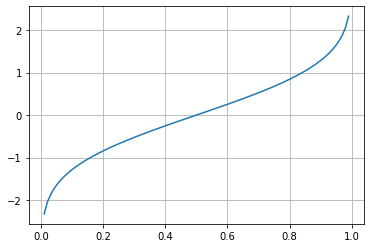

In [10]:
alphas = np.linspace(0,1,100)
plt.plot(alphas, norm.ppf(alphas))
plt.grid()

In [11]:
alpha = 0.05 # 95% of confidence level
for symbol in df.columns:
    print(symbol)
    mu = dfr.loc[symbol]['Expected return']
    sigma = dfr.loc[symbol]['Standard deviation']
    VaR = norm.ppf(alpha, mu, sigma)
    #VaR = mu - sigma*norm.ppf(1-alpha) # alternative solution (see http://www.quantatrisk.com/2017/11/17/re-calibrating-expected-shortfall-value-at-risk-for-discrete-distributions/)
    print(VaR)
    #print(norm.cdf(ppf, mu, sigma)*100) # checking if the ppf function is working properly

APPL
-9.898945522688035
WALMART
-7.315159761608687
IBM
-7.236402008649157
NIKE
-7.84406439428035


For example, the obatined values suggests that APPL has a 95% probability of not suffering losses larger than -9.90% over a one month period.

The problem with the above approach is that it's based on the Normal function, i.e., it assumes the data have slim tails. To avoid this issue, there's a simpler way of evaluating VaR, gotten from the alpha*100 percentil rank or the alpha quantile rank. That's the history based or non-parametric way of evaluating VaR.

In [12]:
alpha = 0.05 # 95% of confidence level
df.quantile(q=alpha, interpolation='linear') # linear interpolation method (see pandas.DataFrame.quantile doc for details)

APPL      -10.7825
WALMART    -5.8745
IBM        -6.5345
NIKE       -5.7545
Name: 0.05, dtype: float64

The expected shortfall (ES) is the expected loss you would have if you lose more than the VaR. Thus, it's a complementary measure to VaR.

If the VaR was evaluated using the historic data, ES can be calculated simply by taking the average of the returns in the (1-alpha) percentil rank.

In [13]:
for symbol, VaR in df.quantile(q=alpha, interpolation='linear').iteritems():
    print(symbol, np.round(df[symbol][df[symbol].lt(VaR)].mean(), 2))

APPL -12.42
WALMART -9.49
IBM -9.83
NIKE -13.63


On the contrary, if VaR was obtained based on the Normal distribution, we must do the following (see http://www.quantatrisk.com/2017/11/17/re-calibrating-expected-shortfall-value-at-risk-for-discrete-distributions/).

In [14]:
alpha = 0.05 # 95% of confidence
for symbol in df.columns:
    #plt.figure(figsize=(8,4))
    print(symbol)
    mu = dfr.loc[symbol]['Expected return']
    sigma = dfr.loc[symbol]['Standard deviation']
    
    #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    #plt.plot(x, norm.pdf(x, mu, sigma))
    
    VaR = mu + sigma * stats.norm.ppf(alpha)
    #print('VaR:', VaR)
    
    #x= np.linspace(mu - 5*sigma, VaR, 1000)
    #plt.plot(x, norm.pdf(x, mu, sigma))
    
    #mult = np.dot(x, norm.pdf(x, mu, sigma)) # brute force method (use together with the plots)
    #print('ES:', mult/norm.pdf(x, mu, sigma).sum())
    
    es = mu - sigma * stats.norm.pdf(stats.norm.ppf(1-alpha))/(alpha)
    print('ES:', es)

APPL
ES: -12.859560187578573
WALMART
ES: -9.310687246449591
IBM
ES: -9.119662862084741
NIKE
ES: -10.371104730889858
